## Compare UI Ekman and UI SST

In [1]:
## import packages
%matplotlib inline
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import matplotlib.patches as mpatches
import matplotlib
import cartopy.crs as ccrs
import glob
import os
import my_functions
import datetime
import statsmodels.api as sm

In [2]:
## import data
os.chdir('/Users/marie-louisekorte/Documents/Uni Leipzig/Lisbon/Data.nosync/')
MTSS = xr.open_dataset('Surface_stress/Turbulent_mean/Turbulent_mean_weekly.nc')
UI_SST = UI_SST = xr.open_dataset('CoastNET_SST_UI.nc')
LSM = xr.open_dataset('ERA5_land_sea_mask.nc')

In [3]:
## preprocessing steps
# add the land sea mask to the MTSS dataset
MTSS['lsm'] = LSM.lsm

# calculate upwelling index from wind stress dataset -> use my upwelling function (from my_functions.py)
UI_Ek = my_functions.calc_upwelling_index(MTSS, MTSS.lat, MTSS.lon, MTSS.metss, MTSS.mntss)

# calculate meridional mean (1D Portuguese upwelling index), does meridional mean of UI by default
UI_Ek = my_functions.calc_meridional_mean(UI_Ek)
UI_SST = my_functions.calc_meridional_mean(UI_SST)

# create subset of summer months, June-September (week 22-39), subsets week 22-39 by default
UI_Ek_summer = my_functions.subset_summer(UI_Ek)
UI_SST_summer = my_functions.subset_summer(UI_SST)

## Plot 

### Single Point near Lisbon

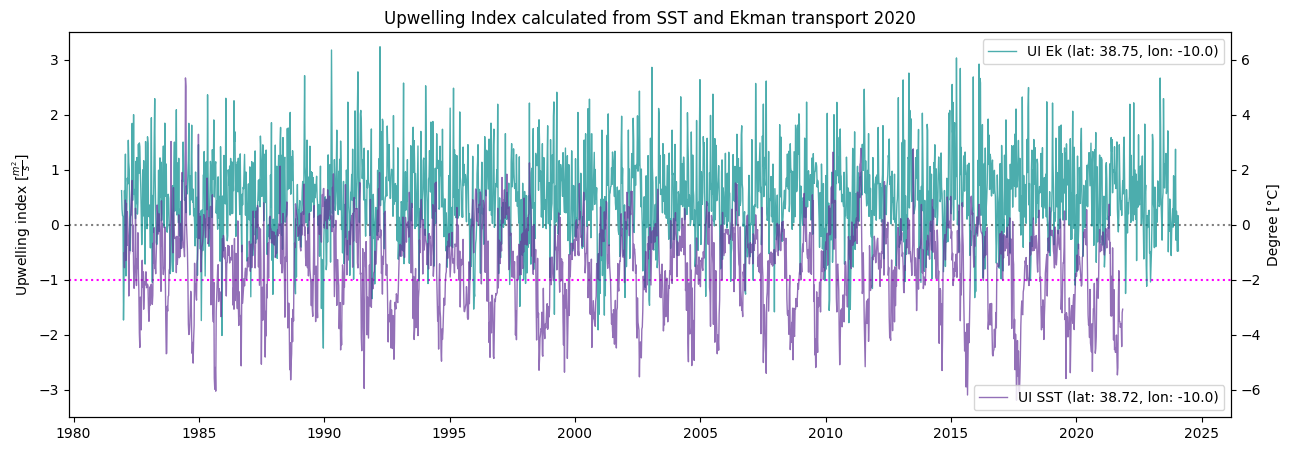

In [4]:
## compare UIs 
fig, ax1 = plt.subplots(figsize=(15,5))

# 0 line
plt.axhline(0, color = 'k', linestyle = ':', alpha = 0.5);
# -2°C line (as signifier for an upwelling event, -2/3 on primary axis = -2 on secondary)
plt.axhline(-1, color = 'magenta', linestyle = ':')

# primary axis
ax1.plot(UI_Ek.time, UI_Ek.UI.sel(lat = 38.7, lon = -10, method = 'nearest'), 
         label = f"UI Ek (lat: {UI_Ek.lat.sel(lat = 38.7, method = 'nearest').values.round(2)}, lon: {UI_Ek.lon.sel(lon = -10, method = 'nearest').values.round(2)})",
         color = 'darkcyan', alpha = 0.7, linewidth = 1)
# secondary axis 
ax2 = ax1.twinx()
ax2.plot(UI_SST.time, UI_SST.UI.sel(lat = 38.7, lon = -10, method = 'nearest'), 
         label = f"UI SST (lat: {UI_SST.lat.sel(lat = 38.7, method = 'nearest').values.round(2)}, lon: {UI_SST.lon.sel(lon = -10, method = 'nearest').values.round(2)})",
         color = 'rebeccapurple', alpha = 0.7, linewidth = 1)

# layout 
ax1.set_ylabel(r'Upwelling index [$\frac{m^{2}}{s}$]');
ax1.set_ylim(-3.5, 3.5)
ax1.legend(loc = 0)

ax2.set_ylabel('Degree [°C]')
ax2.set_ylim(-7,7)
ax2.legend(loc = 4)

plt.title('Upwelling Index calculated from SST and Ekman transport 2020')
plt.xlabel('Time [yr]');

Text(0.5, 0, 'Time [yr-m]')

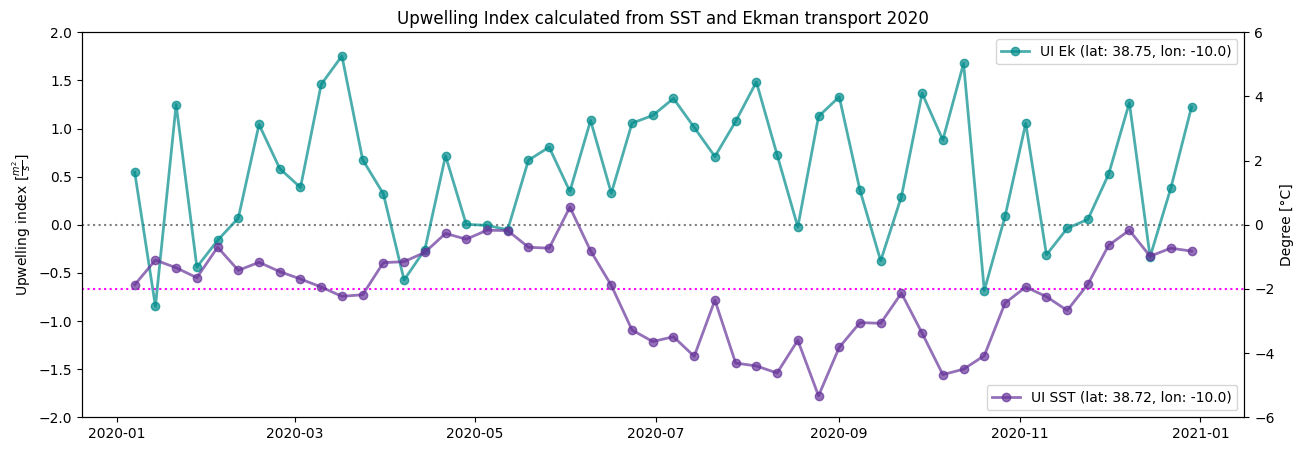

In [5]:
# compare only 1 year of data
fig, ax1 = plt.subplots(figsize=(15,5))

# 0 line
plt.axhline(0, color = 'k', linestyle = ':', alpha = 0.5);
# -2°C line (as signifier for an upwelling event, -2/3 on primary axis = -2 on secondary)
plt.axhline(-2/3, color = 'magenta', linestyle = ':')

# primary axis
ax1.plot(UI_Ek.time.sel(time = slice ("2020-01-01", "2020-12-31")), UI_Ek.UI.sel(time = slice ("2020-01-01", "2020-12-31")).sel(lat = 38.7, lon = -10, method = 'nearest'), 
         label = f"UI Ek (lat: {UI_Ek.lat.sel(lat = 38.7, method = 'nearest').values.round(2)}, lon: {UI_Ek.lon.sel(lon = -10, method = 'nearest').values.round(2)})",
         color = 'darkcyan', alpha = 0.7, linewidth = 2, marker = 'o')

# secondary axis 
ax2 = ax1.twinx()
ax2.plot(UI_SST.time.sel(time = slice ("2020-01-01", "2020-12-31")), UI_SST.UI.sel(time = slice ("2020-01-01", "2020-12-31")).sel(lat = 38.7, lon = -10, method = 'nearest'), 
         label = f"UI SST (lat: {UI_SST.lat.sel(lat = 38.7, method = 'nearest').values.round(2)}, lon: {UI_SST.lon.sel(lon = -10, method = 'nearest').values.round(2)})",
         color = 'rebeccapurple', alpha = 0.7, linewidth = 2, marker = 'o')

# layout 
ax1.set_ylabel(r'Upwelling index [$\frac{m^{2}}{s}$]');
ax1.set_ylim(-2, 2)
ax1.legend(loc = 0)

ax2.set_ylabel('Degree [°C]')
ax2.set_ylim(-6,6)
ax2.legend(loc = 4)

plt.title('Upwelling Index calculated from SST and Ekman transport 2020')
plt.xlabel('Time [yr-m]')


### Overview Lat over Time

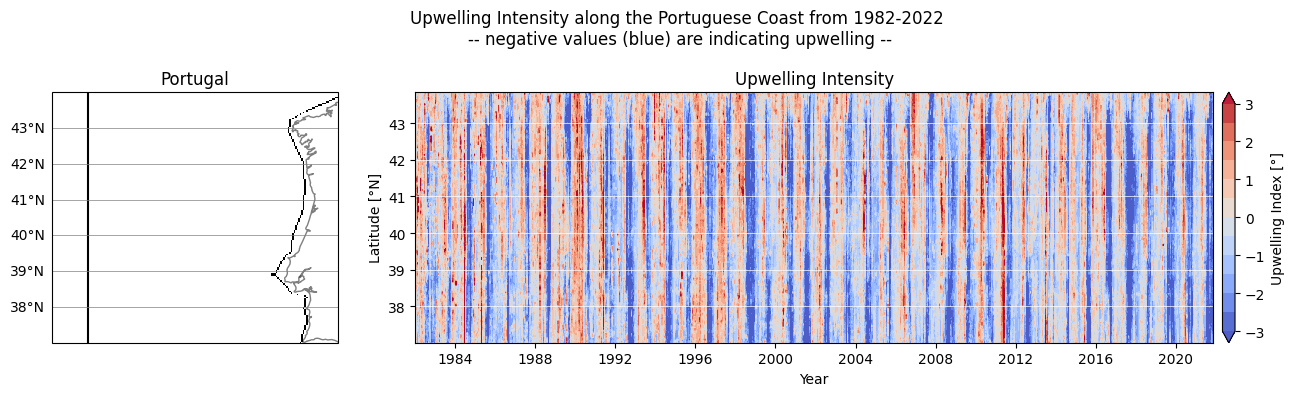

In [6]:
# plot UI SST as a function of time

# set up figure
fig = plt.figure(figsize = (14,4))
gs = fig.add_gridspec(1,2,width_ratios=[1,3])
ax1 = fig.add_subplot(gs[0], projection = ccrs.PlateCarree())
ax2 = fig.add_subplot(gs[1])

# Portugal map
ax1.set_extent([-16, -8, 44, 37])
ax1.coastlines(color = 'black', alpha = 0.5)
gls = ax1.gridlines(draw_labels=False, linewidth = 0.5, color = 'grey')
gls.xlines = False
gls.left_labels = True

# add mid-shelf and 15°W line
UI_SST.Tmid.isel(time = 0).transpose().plot(ax = ax1, cmap = 'Greys_r', levels = np.arange(285, 1000, 1), extend = 'both', 
                                            add_colorbar=False, transform = ccrs.PlateCarree())

lon1, lat1 = ccrs.PlateCarree().transform_point(-15 , 37, ccrs.Geodetic())
lon2, lat2 = ccrs.PlateCarree().transform_point(-15, 44, ccrs.Geodetic())
ax1.plot([lon1, lon2], [lat1, lat2], transform = ccrs.PlateCarree(), color='black', linewidth=1.5)

ax1.set_title('Portugal')

# plot UI SST
#cols = matplotlib.colors.LinearSegmentedColormap.from_list('',['darkcyan','deeppink']) # attempt at creating own colorbar
im2 = ax2.contourf(UI_SST.UI.time.values, UI_SST.lat.values, UI_SST.UI.sel(lon = - 10, method = 'nearest').transpose(), 
             cmap = 'coolwarm', levels = np.arange(-3, 3.5, 0.5), extend = 'both', alpha = 0.9)
ax2.set_ylabel('Latitude [°N]')
ax2.set_xlabel('Year');
ax2.set_title('Upwelling Intensity')
ax2.grid(color = 'white', linewidth = 0.5, axis = 'y')
plt.colorbar(im2, pad = 0.01, label = f'Upwelling Index [°]', ticks = np.arange(-3, 4, 1));

fig.suptitle('Upwelling Intensity along the Portuguese Coast from 1982-2022 \n-- negative values (blue) are indicating upwelling --')
fig.tight_layout()
fig.savefig('../Iberian_Coast_Upwelling/Figures/Overview_UI_SST.png', dpi = 300)

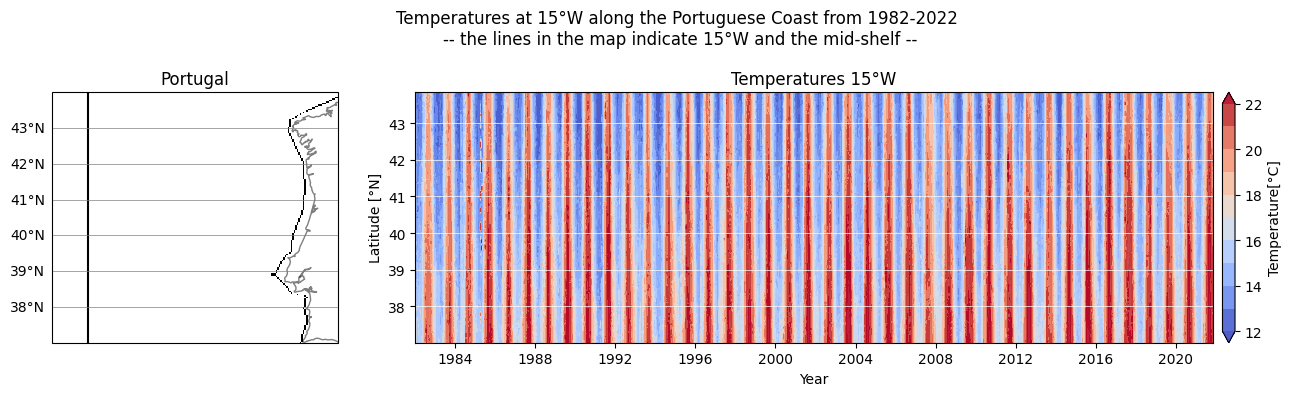

In [7]:
# plot SST Toff15 as a function of time

# set up figure
fig = plt.figure(figsize = (14,4))
gs = fig.add_gridspec(1,2,width_ratios=[1,3])
ax1 = fig.add_subplot(gs[0], projection = ccrs.PlateCarree())
ax2 = fig.add_subplot(gs[1])

# Portugal map
ax1.set_extent([-16, -8, 44, 37])
ax1.coastlines(color = 'black', alpha = 0.5)
gls = ax1.gridlines(draw_labels=False, linewidth = 0.5, color = 'grey')
gls.xlines = False
gls.left_labels = True

# add mid-shelf and 15°W line
UI_SST.Tmid.isel(time = 0).transpose().plot(ax = ax1, cmap = 'Greys_r', levels = np.arange(285, 1000, 1), extend = 'both', 
                                            add_colorbar=False, transform = ccrs.PlateCarree())

lon1, lat1 = ccrs.PlateCarree().transform_point(-15 , 37, ccrs.Geodetic())
lon2, lat2 = ccrs.PlateCarree().transform_point(-15, 44, ccrs.Geodetic())
ax1.plot([lon1, lon2], [lat1, lat2], transform = ccrs.PlateCarree(), color='black', linewidth=1.5)

ax1.set_title('Portugal')

# plot temperatures
im2 = ax2.contourf(UI_SST.UI.time.values, UI_SST.lat.values, (UI_SST.Toff15W.sel(lon = - 15, method = 'nearest').transpose() - 273.15), 
             cmap = 'coolwarm', levels = np.arange(12, 23, 1), extend = 'both', alpha = 0.9)
ax2.set_ylabel('Latitude [°N]')
ax2.set_xlabel('Year');
ax2.set_title('Temperatures 15°W')
ax2.grid(color = 'white', linewidth = 0.5, axis = 'y')
plt.colorbar(im2, pad = 0.01, label = 'Temperature[°C]');

fig.suptitle('Temperatures at 15°W along the Portuguese Coast from 1982-2022 \n-- the lines in the map indicate 15°W and the mid-shelf --')
fig.tight_layout()
fig.savefig('../Iberian_Coast_Upwelling/Figures/Overview_T_15W.png', dpi = 300)

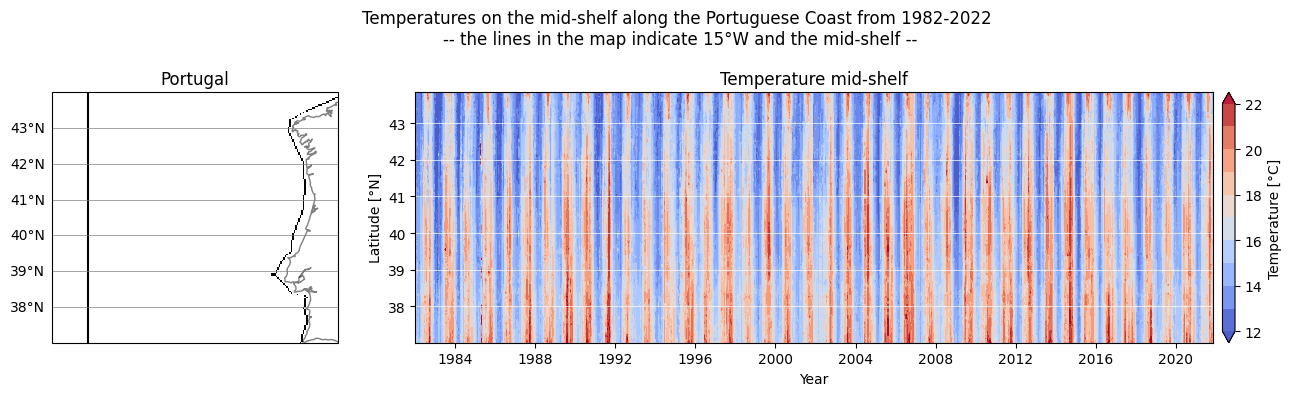

In [8]:
# plot SST Tmid as a function of time

# set up figure
fig = plt.figure(figsize = (14,4))
gs = fig.add_gridspec(1,2,width_ratios=[1,3])
ax1 = fig.add_subplot(gs[0], projection = ccrs.PlateCarree())
ax2 = fig.add_subplot(gs[1])

# Portugal map
ax1.set_extent([-16, -8, 44, 37])
ax1.coastlines(color = 'black', alpha = 0.5)
gls = ax1.gridlines(draw_labels=False, linewidth = 0.5, color = 'grey')
gls.xlines = False
gls.left_labels = True

# add mid-shelf and 15°W line
UI_SST.Tmid.isel(time = 0).transpose().plot(ax = ax1, cmap = 'Greys_r', levels = np.arange(285, 1000, 1), extend = 'both', 
                                            add_colorbar=False, transform = ccrs.PlateCarree())
lon1, lat1 = ccrs.PlateCarree().transform_point(-15 , 37, ccrs.Geodetic())
lon2, lat2 = ccrs.PlateCarree().transform_point(-15, 44, ccrs.Geodetic())
ax1.plot([lon1, lon2], [lat1, lat2], transform = ccrs.PlateCarree(), color='black', linewidth=1.5)

ax1.set_title('Portugal')


# plot temperatures
im2 = ax2.contourf(UI_SST.UI.time.values, UI_SST.lat.values, UI_SST.Tmid.sum(dim = 'lon').transpose() - 273.15, 
             cmap = 'coolwarm', levels = np.arange(12, 23, 1), extend = 'both', alpha = 0.9)
ax2.set_ylabel('Latitude [°N]')
ax2.set_xlabel('Year');
ax2.set_title('Temperature mid-shelf')
ax2.grid(color = 'white', linewidth = 0.5, axis = 'y')
plt.colorbar(im2, pad = 0.01, label = 'Temperature [°C]');

fig.suptitle('Temperatures on the mid-shelf along the Portuguese Coast from 1982-2022 \n-- the lines in the map indicate 15°W and the mid-shelf --')
fig.tight_layout()
fig.savefig('../Iberian_Coast_Upwelling/Figures/Overview_T_mid.png', dpi = 300)

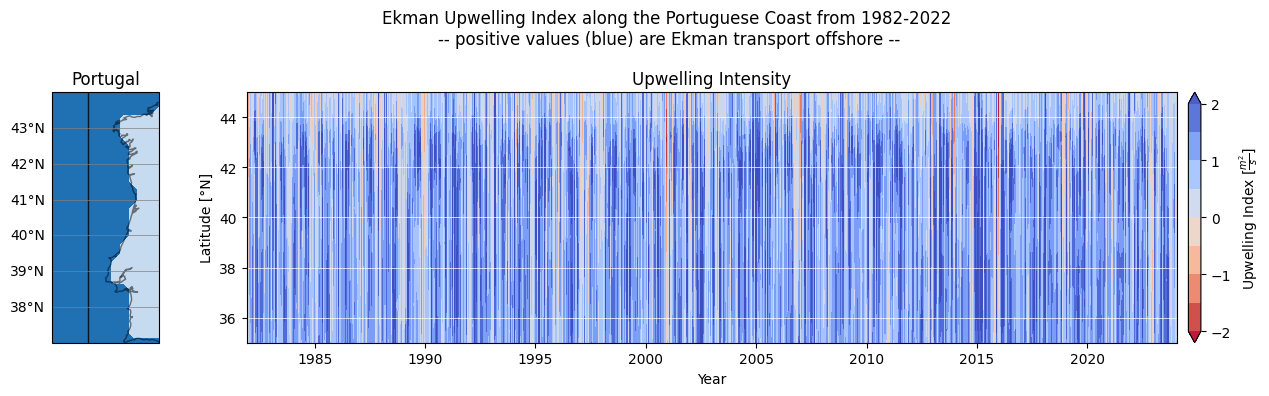

In [9]:
# plot UI Ek as a function of time

# set up figure
fig = plt.figure(figsize = (14,4))
gs = fig.add_gridspec(1,2,width_ratios=[1,7])
ax1 = fig.add_subplot(gs[0], projection = ccrs.PlateCarree())
ax2 = fig.add_subplot(gs[1])

# Portugal map
ax1.set_extent([-11, -8, 44, 37])
ax1.coastlines(color = 'black', alpha = 0.5)
gls = ax1.gridlines(draw_labels=False, linewidth = 0.5, color = 'grey')
gls.xlines = False
gls.left_labels = True

# plot ERA5 land mask
ax1.contourf(UI_Ek.lon, UI_Ek.lat, UI_Ek.lsm, cmap = 'Blues', transform = ccrs.PlateCarree())

# plot 10°W line (line I am plotting my UI Ek for)
lon1, lat1 = ccrs.PlateCarree().transform_point(-10 , 37, ccrs.Geodetic())
lon2, lat2 = ccrs.PlateCarree().transform_point(-10, 44, ccrs.Geodetic())
ax1.plot([lon1, lon2], [lat1, lat2], transform = ccrs.PlateCarree(), color='black', linewidth=1, alpha = 0.8)

ax1.set_title('Portugal')

# plot UI Ek
im2 = ax2.contourf(UI_Ek.time.values, UI_Ek.lat.values, UI_Ek.UI.sel(lon = - 10, method = 'nearest').transpose(), 
             cmap = 'coolwarm_r', levels = np.arange(-2, 2.5, 0.5), extend = 'both', alpha = 0.9)
ax2.set_ylabel('Latitude [°N]')
ax2.set_xlabel('Year');
ax2.set_title('Upwelling Intensity')
ax2.grid(color = 'white', linewidth = 0.5, axis = 'y')
plt.colorbar(im2, pad = 0.01, label = r'Upwelling Index [$\frac{m^2}{s}$]', ticks = np.arange(-2, 3, 1));

fig.suptitle('Ekman Upwelling Index along the Portuguese Coast from 1982-2022 \n-- positive values (blue) are Ekman transport offshore --')
fig.tight_layout()
fig.savefig('../Iberian_Coast_Upwelling/Figures/Overview_UI_Ekman.png', dpi = 300)

## Trends

Text(0.5, 1.0, 'Mean Summer (Jun-Sep) Upwelling Trend Ek')

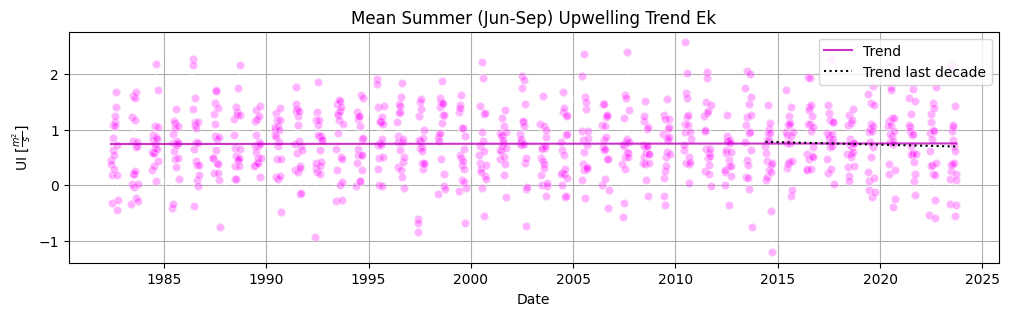

In [10]:
# get values for the trend line analysis
fig = plt.figure(figsize = (12, 3))

x_dates = UI_Ek_summer.time
x_num = dates.date2num(x_dates)
x_num_10 = x_num[-180:-1]

y = UI_Ek_summer.UI_mean

# calculate a fit line
trend = np.polyfit(x_num, y, 1)
fit = np.poly1d(trend)

# calculate fitline only for past decade
trend_10 = np.polyfit(x_num_10, y[-180:-1], 1)
fit_10 = np.poly1d(trend_10)

# general plot again
plt.plot(x_dates, y, marker = 'o', markerfacecolor = 'magenta', alpha = 0.3, color = 'white')
plt.xlabel('Date')
plt.ylabel(r'UI [$\frac{m^2}{s}$]')

# get the input numbers for the fit line and convert the numbers back to dates
x_fit = np.linspace(x_num.min(), x_num.max())
plt.plot(dates.num2date(x_fit), fit(x_fit), "m-", alpha = 0.8, label = 'Trend') 

# last 10 years
x_fit_10 = np.linspace(x_num_10.min(), x_num_10.max())
plt.plot(dates.num2date(x_fit_10), fit_10(x_fit_10), "k:", alpha = 1, label = 'Trend last decade') 

plt.legend()
plt.grid()
plt.title('Mean Summer (Jun-Sep) Upwelling Trend Ek')

Text(0.5, 1.0, 'Mean Summer (Jun-Sep) Upwelling Trend SST')

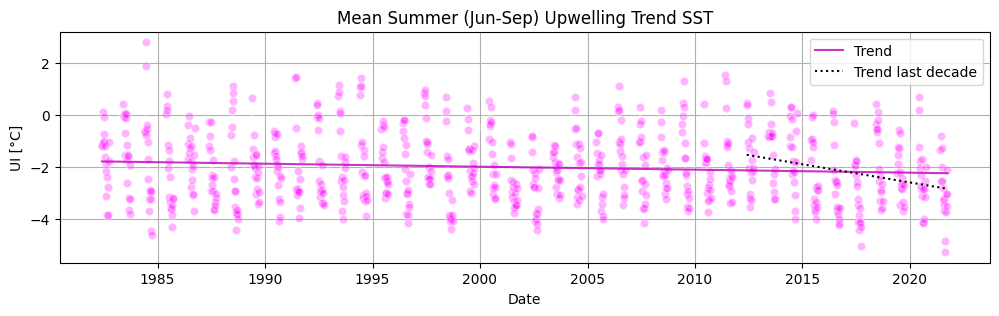

In [12]:
# get values for the trend line analysis
fig = plt.figure(figsize = (12, 3))

x_dates = UI_SST_summer.time
x_num = dates.date2num(x_dates)
x_num_10 = x_num[-180:-1]

y = UI_SST_summer.UI_mean

# calculate a fit line
trend = np.polyfit(x_num, y, 1)
fit = np.poly1d(trend)

# calculate fitline only for past decade
trend_10 = np.polyfit(x_num_10, y[-180:-1], 1)
fit_10 = np.poly1d(trend_10)

# general plot 
plt.plot(x_dates, y, marker = 'o', markerfacecolor = 'magenta', alpha = 0.3, color = 'white')
plt.xlabel('Date')
plt.ylabel(r'UI [°C]')

# get the input numbers for the fit line and convert the numbers back to dates
x_fit = np.linspace(x_num.min(), x_num.max())
plt.plot(dates.num2date(x_fit), fit(x_fit), "m-", alpha = 0.8, label = 'Trend')

# last 10 years
x_fit_10 = np.linspace(x_num_10.min(), x_num_10.max())
plt.plot(dates.num2date(x_fit_10), fit_10(x_fit_10), "k:", alpha = 1, label = 'Trend last decade') 

plt.legend()
plt.grid()
plt.title('Mean Summer (Jun-Sep) Upwelling Trend SST')

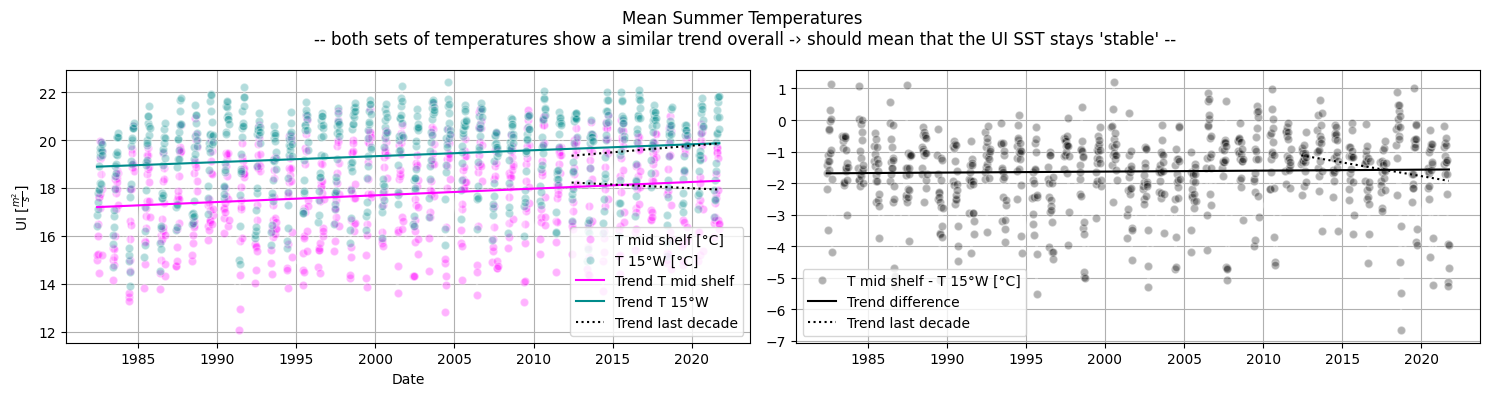

In [34]:
# get values for the trend line analysis
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (15, 4))

x_dates = UI_SST_summer.time
x_num = dates.date2num(x_dates)
x_num_10 = x_num[-180:-1]


y1 = my_functions.calc_meridional_mean(UI_SST_summer, variable = 'Tmid', lon = -8)
y1 = y1.Tmid_mean - 273.15
y2 = my_functions.calc_meridional_mean(UI_SST_summer, variable = 'Toff15W', lon = -15)
y2 = y2.Toff15W_mean - 273.15

# calculate a fit line
trend1 = np.polyfit(x_num, y1, 1)
fit1 = np.poly1d(trend1)

trend2 = np.polyfit(x_num, y2, 1)
fit2 = np.poly1d(trend2)

# calculate fit for last decade
trend1_10 = np.polyfit(x_num_10, y1[-180:-1], 1)
fit1_10 = np.poly1d(trend1_10)

trend2_10 = np.polyfit(x_num_10, y2[-180:-1], 1)
fit2_10 = np.poly1d(trend2_10)

# general plot
ax1.plot(x_dates, y1, marker = 'o', markerfacecolor = 'magenta', alpha = 0.3, color = 'white' , label = 'T mid shelf [°C]')
ax1.plot(x_dates, y2, marker = 'o', markerfacecolor = 'darkcyan', alpha = 0.3, color = 'white', label = 'T 15°W [°C]')
ax1.set_xlabel('Date')
ax1.set_ylabel(r'UI [$\frac{m^2}{s}$]')

# get the input numbers for the fit line and convert the numbers back to dates
x_fit = np.linspace(x_num.min(), x_num.max())
ax1.plot(dates.num2date(x_fit), fit1(x_fit), "magenta", label = 'Trend T mid shelf')
ax1.plot(dates.num2date(x_fit), fit2(x_fit), "darkcyan", label = 'Trend T 15°W')

x_fit = np.linspace(x_num_10.min(), x_num_10.max())
ax1.plot(dates.num2date(x_fit), fit1_10(x_fit), "k:", label = 'Trend last decade')
ax1.plot(dates.num2date(x_fit), fit2_10(x_fit), "k:")

ax1.legend()
ax1.grid()

x_fit = np.linspace(x_num.min(), x_num.max())
ax2.plot(x_dates, y1-y2, marker = 'o', markerfacecolor = 'black', alpha = 0.3, color = 'white' , label = 'T mid shelf - T 15°W [°C]')
ax2.plot(dates.num2date(x_fit), fit1(x_fit) - fit2(x_fit), 'k', label = 'Trend difference')

x_fit = np.linspace(x_num_10.min(), x_num_10.max())
ax2.plot(dates.num2date(x_fit), fit1_10(x_fit) - fit2_10(x_fit), 'k:', label = 'Trend last decade')
ax2.legend()
ax2.grid()

fig.suptitle("Mean Summer Temperatures \n-- both sets of temperatures show a similar trend overall -› should mean that the UI SST stays 'stable' --")
fig.tight_layout()

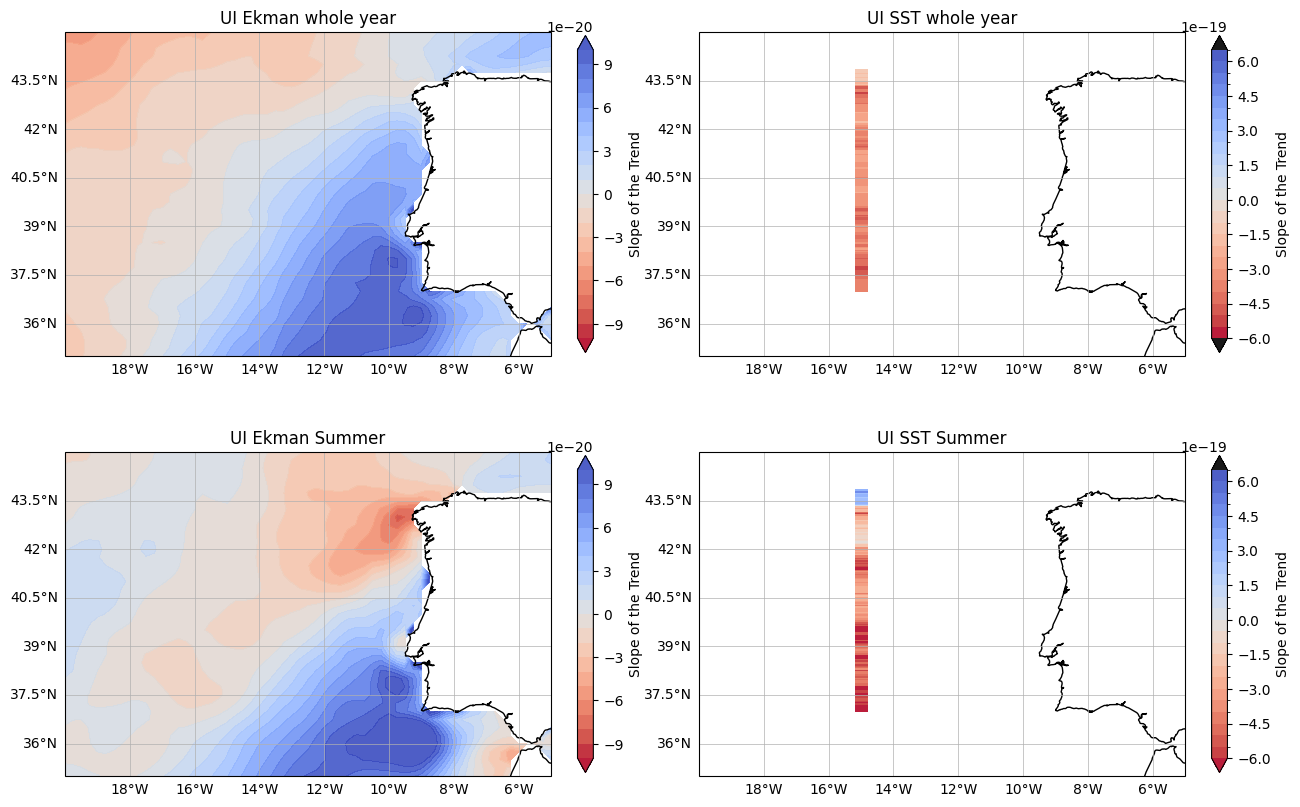

In [14]:
# https://stackoverflow.com/questions/70767908/calculate-linear-trend-in-each-grid-cell
xsize = 2
ysize = 2
fig, axs = plt.subplots(xsize, ysize, figsize = (15, 10), subplot_kw={'projection': ccrs.PlateCarree()})

Vars = [UI_Ek.UI, UI_Ek_summer.UI, UI_SST.UI, UI_SST_summer.UI]
title = ['UI Ekman whole year', 'UI Ekman Summer', 'UI SST whole year', 'UI SST Summer']
i = 0
for x in np.arange(0, xsize):
    for y in np.arange(0, ysize):
        ax = axs[y,x]
        #ax = axs[x]

        # set up cartopy
        ax.set_extent([-20, -5, 45, 35])
        ax.coastlines()
        gls = ax.gridlines(draw_labels=True, linewidth = 0.5)
        gls.top_labels = False 
        gls.right_labels = False

        DS = Vars[i]
        result = DS.polyfit(dim = "time", deg = 1)
        
        if i <= 1:
            
            im = ax.contourf(result.lon, result.lat, result.polyfit_coefficients.sel(degree=1).where(UI_Ek.lsm), 
                         cmap = 'coolwarm_r', levels = np.arange(-1e-19, 1.1e-19, 0.1e-19), extend = 'both', alpha = 0.9)
            plt.colorbar(im, fraction = 0.03, label = 'Slope of the Trend')
            
        if i >1:
            im = result.polyfit_coefficients.sel(lon = slice(-20, -5)).sel(degree=1).plot(ax = ax, x = 'lon',
                         cmap = 'coolwarm_r', levels = np.arange(-6e-19, 7e-19, 0.5e-19), alpha = 0.9, add_colorbar=False)
            plt.colorbar(im, fraction = 0.03, label = 'Slope of the Trend', extend = 'both')
            # add patches to focus on 15°W (otherwise plot shows wider strip from ~18°w to ~8°W)
            ax.add_patch(mpatches.Rectangle(xy=[-18, 36], width = 2.8, height = 8, facecolor = 'white', transform = ccrs.PlateCarree()))
            ax.add_patch(mpatches.Rectangle(xy=[-14.8, 36], width = 8, height = 8, facecolor = 'white', transform = ccrs.PlateCarree()))
    
        ax.set_title(f'{title[i]}')

        i = i+1

## Trend in upwelling events (count of weeks)

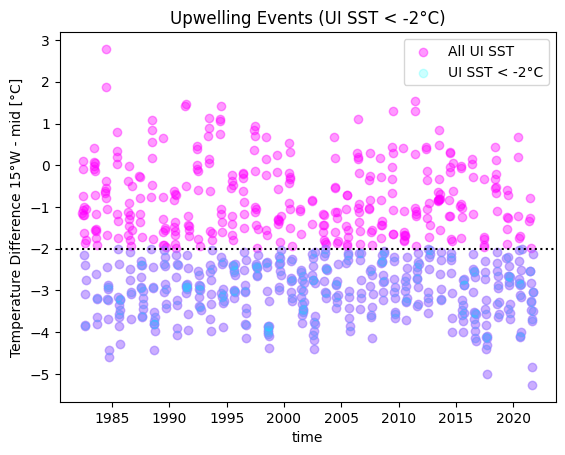

In [15]:
# overview over upwelling events UI SST
UI_SST_summer.UI_mean.plot.scatter(color = 'magenta', alpha = 0.4, label = 'All UI SST')
UI_SST_summer.UI_mean.where(UI_SST_summer.UI_mean < -2).plot.scatter(color = 'cyan', alpha = 0.2, label = 'UI SST < -2°C')
plt.title('Upwelling Events (UI SST < -2°C)')
plt.legend();
plt.ylabel('Temperature Difference 15°W - mid [°C]');
plt.axhline(-2, color = 'k', linestyle = ':');

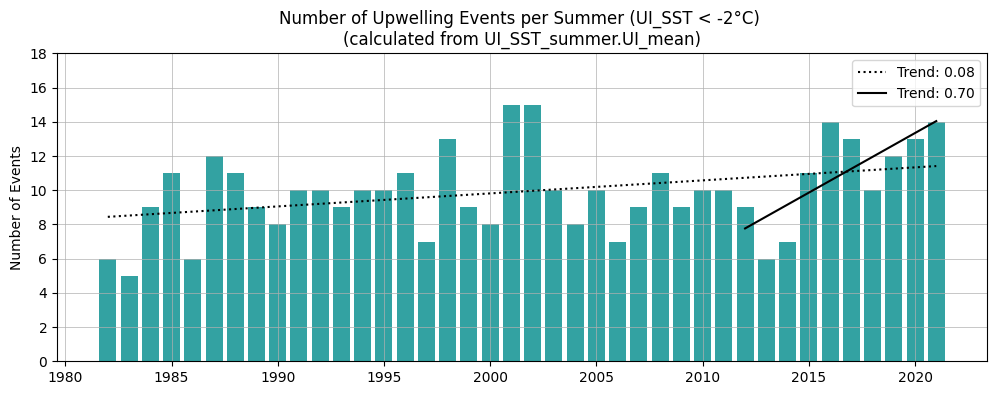

In [81]:
## number of upwelling events UI SST -> defined as UI_SST < -2°
fig = plt.figure(figsize = (12,4))

UI_SST_summer_event = UI_SST_summer.UI_mean.where(UI_SST_summer.UI_mean < -2).groupby('time.year').count(dim = 'time')
years = UI_SST_summer_event.year
plt.bar(years, UI_SST_summer_event, color = 'darkcyan', alpha = 0.8)
plt.title('Number of Upwelling Events per Summer (UI_SST < -2°C) \n(calculated from UI_SST_summer.UI_mean)')
plt.ylabel('Number of Events');

# calculate trend line full period
result = UI_SST_summer_event.polyfit(dim = 'year', deg = 1) 
a = result.polyfit_coefficients.sel(degree=1).values
b = result.polyfit_coefficients.sel(degree=0).values

plt.plot(years, a * years + b, 'k:', label = f'Trend: {a:.2f}');

# calculate trend last decade
result = UI_SST_summer_event[-10:].polyfit(dim = 'year', deg = 1) 
a = result.polyfit_coefficients.sel(degree=1).values
b = result.polyfit_coefficients.sel(degree=0).values

plt.plot(years[-10:], a * years[-10:] + b, 'k', label = f'Trend: {a:.2f}');

plt.legend()
plt.grid(linewidth = 0.5)
plt.yticks(np.arange(0,20,2));

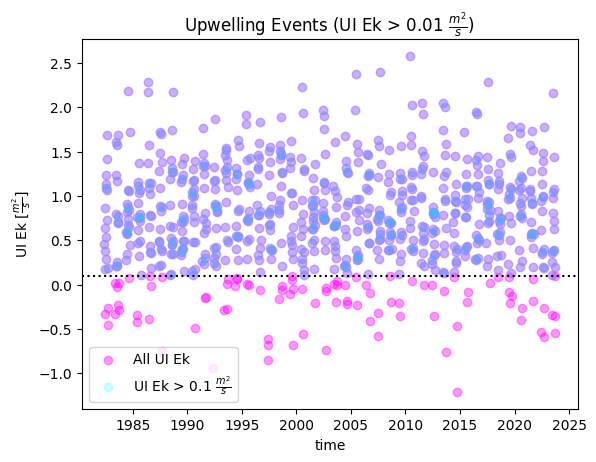

In [17]:
# overview over upwelling events UI Ek
UI_Ek_summer.UI_mean.plot.scatter(color = 'magenta', alpha = 0.4, label = 'All UI Ek')
UI_Ek_summer.UI_mean.where(UI_Ek_summer.UI_mean > 0.1).plot.scatter(color = 'cyan', alpha = 0.2, label = r'UI Ek > 0.1 $\frac{m^2}{s}$')
plt.title(r'Upwelling Events (UI Ek > 0.01 $\frac{m^2}{s}$)')
plt.legend();
plt.ylabel(r'UI Ek [$\frac{m^2}{s}$]');
plt.axhline(0.1, color = 'k', linestyle = ':');

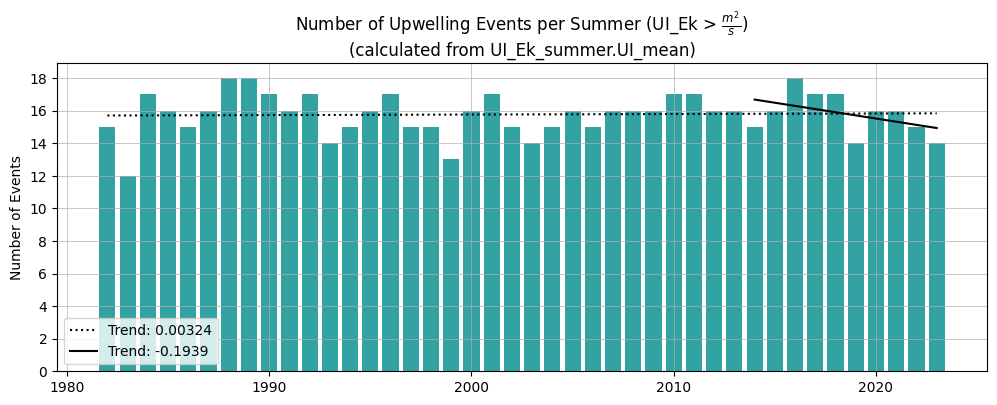

In [53]:
## number of upwelling events UI Ek -> defined as UI_Ek > 0.1 m2/s
fig = plt.figure(figsize = (12,4))

UI_Ek_summer_event = UI_Ek_summer.UI_mean.where(UI_Ek_summer.UI_mean > 0.1).groupby('time.year').count(dim = 'time')
years = UI_Ek_summer_event.year
plt.bar(years, UI_Ek_summer_event, color = 'darkcyan', alpha = 0.8)
plt.title(r'Number of Upwelling Events per Summer (UI_Ek > $\frac{m^2}{s}$)''\n(calculated from UI_Ek_summer.UI_mean)')
plt.ylabel('Number of Events');

# calculate trend whole period
result = UI_Ek_summer_event.polyfit(dim = 'year', deg = 1) 
a = result.polyfit_coefficients.sel(degree=1).values
b = result.polyfit_coefficients.sel(degree=0).values

plt.plot(years, a * years + b, 'k:', label = f'Trend: {a:.5f}');

# calculate trend last decade
result = UI_Ek_summer_event[-10:].polyfit(dim = 'year', deg = 1) 
a = result.polyfit_coefficients.sel(degree=1).values
b = result.polyfit_coefficients.sel(degree=0).values

plt.plot(years[-10:], a * years[-10:] + b, 'k', label = f'Trend: {a:.4f}');

plt.legend()
plt.grid(linewidth = 0.5)
plt.yticks(np.arange(0,20,2));

## Significance of Trends

In [90]:
## UI_Ek whole period -> just as a tester that gives me all the inofr with model.summary()
time = np.arange(0, len(UI_Ek_summer.time))
values = UI_Ek_summer.UI_mean.values

time_with_const = sm.add_constant(time)

model = sm.OLS(values, time_with_const).fit()   ## OLS -> ordinary least squares

print('UI_Ek whole period')
print(model.summary()) # check options dir(model) or even dir(model.parameters)

UI_Ek whole period
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                  0.009177
Date:                Mon, 20 May 2024   Prob (F-statistic):              0.924
Time:                        17:01:03   Log-Likelihood:                -663.81
No. Observations:                 756   AIC:                             1332.
Df Residuals:                     754   BIC:                             1341.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7430      0.042 

In [88]:
## UI_Ek whole period
time = np.arange(0, len(UI_Ek_summer.time))
values = UI_Ek_summer.UI_mean.values

time_with_const = sm.add_constant(time)
model = sm.OLS(values, time_with_const).fit()   ## OLS -> ordinary least squares

print('UI_Ek whole period')
print(f' Trend: {model.params[1]:.5f} \n R^2: {model.rsquared:.5f} \n p-value: {model.pvalues[1]:.5f} \n')

## UI_Ek last decace
time = np.arange(0, len(UI_Ek_summer.time.isel(time = slice(-170, None))))
values = UI_Ek_summer.UI_mean.isel(time = slice(-170, None)).values

time_with_const = sm.add_constant(time)
model = sm.OLS(values, time_with_const).fit()   ## OLS -> ordinary least squares

print('UI_Ek last decade')
print(f' Trend: {model.params[1]:.5f} \n R^2: {model.rsquared:.5f} \n p-value: {model.pvalues[1]:.5f} \n')

## UI_Ek number of events whole period
time = np.arange(0, len(UI_Ek_summer_event.year))
values = UI_Ek_summer_event.values

time_with_const = sm.add_constant(time)
model = sm.OLS(values, time_with_const).fit()   ## OLS -> ordinary least squares

print('UI_Ek number of events last decade')
print(f' Trend: {model.params[1]:.5f} \n R^2: {model.rsquared:.5f} \n p-value: {model.pvalues[1]:.5f} \n')

## UI_Ek number of events last decade
time = np.arange(0, len(UI_Ek_summer_event.year[-10:]))
values = UI_Ek_summer_event[-10:].values

time_with_const = sm.add_constant(time)
model = sm.OLS(values, time_with_const).fit()   ## OLS -> ordinary least squares

print('UI_Ek number of events last decade')
print(f' Trend: {model.params[1]:.5f} \n R^2: {model.rsquared:.5f} \n p-value: {model.pvalues[1]:.5f} \n')

print('All p-values are > 0.5 i.e. we accept the H0 of no trend. \nThe trends are non-significant.')

UI_Ek whole period
 Trend: 0.00001 
 R^2: 0.00001 
 p-value: 0.92371 

UI_Ek last decade
 Trend: -0.00094 
 R^2: 0.00625 
 p-value: 0.30554 

UI_Ek number of events last decade
 Trend: 0.00324 
 R^2: 0.00093 
 p-value: 0.84787 

UI_Ek number of events last decade
 Trend: -0.19394 
 R^2: 0.19891 
 p-value: 0.19638 

All p-values are > 0.5 i.e. we accept the H0 of no trend. 
The trends are non-significant.


In [89]:
## UI_SST whole period
time = np.arange(0, len(UI_SST_summer.time))
values = UI_SST_summer.UI_mean.values

time_with_const = sm.add_constant(time)
model = sm.OLS(values, time_with_const).fit()   ## OLS -> ordinary least squares

print('UI_SST whole period')
print(f' Trend: {model.params[1]:.5f} \n R^2: {model.rsquared:.5f} \n p-value: {model.pvalues[1]:.5f} \n')

## UI_SST last decace
time = np.arange(0, len(UI_SST_summer.time.isel(time = slice(-170, None))))
values = UI_SST_summer.UI_mean.isel(time = slice(-170, None)).values

time_with_const = sm.add_constant(time)
model = sm.OLS(values, time_with_const).fit()   ## OLS -> ordinary least squares

print('UI_SST last decade')
print(f' Trend: {model.params[1]:.5f} \n R^2: {model.rsquared:.5f} \n p-value: {model.pvalues[1]:.5f} \n')

## UI_SST number of events whole period
time = np.arange(0, len(UI_SST_summer_event.year))
values = UI_SST_summer_event.values

time_with_const = sm.add_constant(time)
model = sm.OLS(values, time_with_const).fit()   ## OLS -> ordinary least squares

print('UI_SST number of events last decade')
print(f' Trend: {model.params[1]:.5f} \n R^2: {model.rsquared:.5f} \n p-value: {model.pvalues[1]:.5f} \n')

## UI_SST number of events last decade
time = np.arange(0, len(UI_SST_summer_event.year[-10:]))
values = UI_SST_summer_event[-10:].values

time_with_const = sm.add_constant(time)
model = sm.OLS(values, time_with_const).fit()   ## OLS -> ordinary least squares

print('UI_SST number of events last decade')
print(f' Trend: {model.params[1]:.5f} \n R^2: {model.rsquared:.5f} \n p-value: {model.pvalues[1]:.5f} \n')

print('All p-values are < 0.5 i.e. we can reject the H0 of no trend. \nThe trends are significant.')

UI_SST whole period
 Trend: -0.00071 
 R^2: 0.01209 
 p-value: 0.00314 

UI_SST last decade
 Trend: -0.00869 
 R^2: 0.10193 
 p-value: 0.00002 

UI_SST number of events last decade
 Trend: 0.07608 
 R^2: 0.12813 
 p-value: 0.02334 

UI_SST number of events last decade
 Trend: 0.69697 
 R^2: 0.54974 
 p-value: 0.01412 

All p-values are < 0.5 i.e. we can reject the H0 of no trend. 
The trends are significant.
